In [1]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, ELU
from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Lambda
import pickle
from scipy import misc
from scipy.misc import imresize
from PIL import Image
import glob, os
import cv2
import csv
import math
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
import json
%matplotlib inline

Using TensorFlow backend.


In [2]:
learning_rate = 0.0001
batch_size = 128
nb_epoch = 5

In [3]:
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    #costants
    a = -0.5
    b = 0.5
    xmin = np.min(image_data)
    xmax = np.max(image_data) 
    
    x = image_data    
    x_prime = a + ((x-xmin)*(b-a))/(xmax-xmin)
    
    return x_prime



In [4]:

def crop_image(image):
    #New sizes for image, suggested the Vivek in here 
    #https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.n2mwq1z33
    col, row = 64,64
    
    shape = image.shape
    
    #Cut off the sky from the original picture
    crop_up = shape[0]/3
    
    #Cut off the front of the car
    crop_down = shape[0]-25

    image = image[crop_up:crop_down, 0:shape[1]]
    image = cv2.resize(image,(col,row), interpolation=cv2.INTER_AREA)    
    return image

In [5]:
images_list = []

for infile in glob.glob("IMG/center*.jpg"):
    image = misc.imread(infile)
    #image = misc.imresize(image, (66,200))
    images_list.append(image)
    
X_train = np.stack(images_list)
print(X_train.shape)

(8036, 160, 320, 3)


/home/josemacenteno/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


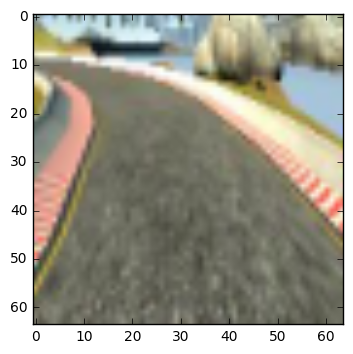

In [19]:
image = X_train[0]
image_preprocessed = crop_image(image)
imgplot = plt.imshow(image_preprocessed)



In [6]:

images_list = []
for image in X_train:
    cropped_image = crop_image(image)
    images_list.append(cropped_image)
   

/home/josemacenteno/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
with open('driving_log.csv','r') as file:
    datareader = csv.reader(file,delimiter=',')
    driving_log = []
    for row in datareader:
        driving_log.append(row)
        
driving_log.pop(0)
        
log = np.stack(driving_log)
print(log.shape)

#labels
y_train = np.zeros(log.shape[0])
for i,row in enumerate(log):
    y_train[i] = log[i][3]
    
    
print (y_train.shape)

(8036, 7)
(8036,)


In [17]:
col_nvidia, row_nvidia = 200,66
resized_images = []
for image in images_list:
    resized_image = cv2.resize(image,(col_nvidia,row_nvidia), interpolation=cv2.INTER_AREA)  
    resized_images.append(resized_image)
    
print('Data normalized')

X_train = np.array(resized_images)
print(X_train.shape)

Data normalized
(8036, 66, 200, 3)


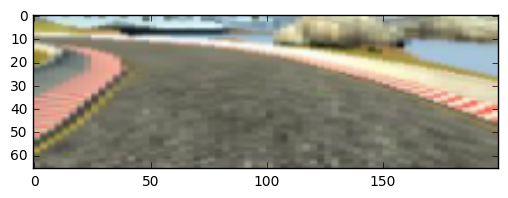

In [15]:

image = resized_images [0]
imgplot = plt.imshow(image)

In [18]:
model = Sequential()
model.add(Lambda(lambda x:x/127.5 -1., input_shape = (66,200,3)))
model.add(Convolution2D(24, 5, 5,border_mode='valid',subsample=(2,2), dim_ordering='tf', input_shape=(66,200,3), init='he_normal'))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, border_mode='valid',subsample=(2,2), init='he_normal'))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, border_mode='valid',subsample=(2,2),init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode='valid',subsample=(1,1),init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode='valid',subsample=(1,1),init='he_normal'))
model.add(Flatten())
model.add(ELU())
model.add(Dense(1164,init='he_normal'))
model.add(ELU())
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(1,name='output',init='he_normal'))

In [19]:
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.3, shuffle=True)

Train on 5625 samples, validate on 2411 samples
Epoch 1/5
5625/5625 [==============================] - 50s - loss: 0.0168 - acc: 0.5452 - val_loss: 0.0168 - val_acc: 0.5367
Epoch 2/5
5625/5625 [==============================] - 49s - loss: 0.0164 - acc: 0.5452 - val_loss: 0.0186 - val_acc: 0.5367
Epoch 3/5
5625/5625 [==============================] - 49s - loss: 0.0161 - acc: 0.5452 - val_loss: 0.0191 - val_acc: 0.5367
Epoch 4/5
5625/5625 [==============================] - 49s - loss: 0.0158 - acc: 0.5452 - val_loss: 0.0167 - val_acc: 0.5367
Epoch 5/5
5625/5625 [==============================] - 49s - loss: 0.0155 - acc: 0.5452 - val_loss: 0.0182 - val_acc: 0.5367


In [20]:
print(history.history['acc'][-1])

0.545244444709


In [21]:
json_string = model.to_json()
with open('model.json','w') as f:
    json.dump(json_string,f,ensure_ascii=False)

model.save_weights('model.h5')